# Statistical analysis and visualization of the results from Mask R-CNN and ORCNN

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import csv
import seaborn as sns

import statistics

import scipy
from scipy.stats import wilcoxon
from scipy.stats import linregress

scipyversion = scipy.__version__
versionnumber = int(scipyversion[0] + scipyversion[2])

if versionnumber < 15:
    from scipy.stats import median_absolute_deviation as median_abs_deviation
else:
    from scipy.stats import median_abs_deviation

from scipy import stats
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Initialize some paths and variables

In [2]:
path_parent = os.path.dirname(os.getcwd())
rootdir = os.path.join(path_parent, "results")

subdirs = ["mrcnn_postprocessing", "orcnn_postprocessing"]
labels = ["Mask R-CNN", "ORCNN"]
colors = ["green", "blue"]
palette = {"g", "b"}

image_num = 487
font_size = 11
digit_size = 9

## Store the results in one array

In [3]:
data_combined = np.zeros((image_num*len(subdirs), 16), dtype = object)
counter = 0

for i in range(len(subdirs)):
    subdir = subdirs[i]
    label = labels[i]
    readdir = os.path.join(rootdir, subdir)
    csvfile = "results_" + subdir + ".csv"

    readfile = os.path.join(readdir, csvfile)

    with open(readfile, 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        next(csv_reader, None)
        for row in csv_reader:
            img_name = row[0]
            detection_num = row[1]
            amodal_iou = row[2]
            visible_iou = row[3]
            estimated_diameter = row[4]
            real_diameter = row[5]
            diff = row[6]
            ocr = row[7]
            analysis_time_cnn = row[8]
            analysis_time_cf = row[9]
            analysis_time_hf = row[10]
            analysis_time_pm = row[11]

            data_combined[counter, 0] = img_name
            data_combined[counter, 1] = int(detection_num)
            data_combined[counter, 2] = float(amodal_iou)
            data_combined[counter, 3] = float(visible_iou)
            data_combined[counter, 4] = float(estimated_diameter)
            data_combined[counter, 5] = float(real_diameter)
            data_combined[counter, 6] = float(diff)
            data_combined[counter, 7] = abs(float(diff))
            data_combined[counter, 8] = round(statistics.ceil_to_decimal(float(ocr)), 1)
            data_combined[counter, 9] = float(analysis_time_cnn)*1000
            data_combined[counter, 10] = float(analysis_time_cf)*1000
            data_combined[counter, 11] = float(analysis_time_hf)*1000
            data_combined[counter, 12] = float(analysis_time_pm)*1000
            data_combined[counter, 13] = float(float(analysis_time_cnn) + float(analysis_time_cf) + float(analysis_time_hf) + float(analysis_time_pm))*1000
            data_combined[counter, 14] = i
            data_combined[counter, 15] = label
            counter = counter+1

## Initialize a dataframe, which will store the results

In [4]:
df = pd.DataFrame(data=data_combined, columns=["name", "det_num", "amodal_iou", "visible_iou", "pred_d", "real_d", "diff", "abs_diff", "ocr", "time_cnn", "time_cf", "time_hf", "time_pm", "time", "method_id", "method"])
df["det_num"] = df["det_num"].astype(int)

df["abs_diff"] = df["abs_diff"].astype(float)
avg_diff = df.groupby(["method"])["abs_diff"].mean()
max_diff = df.groupby(["method"])["abs_diff"].max()

df["diff"] = df["diff"].astype(float)
diffs = df.groupby(["method"])["diff"].apply(list)
pred_diameters = df.groupby(["method"])["pred_d"].apply(list)
real_diameters = df.groupby(["method"])["real_d"].apply(list)

df["amodal_iou"] = df["amodal_iou"].astype(float)
df["visible_iou"] = df["visible_iou"].astype(float)
df["time"] = df["time"].astype(float)
df["method_id"] = df["method_id"].astype(int)

## Do some summary statistics and plot a histogram

Mask R-CNN


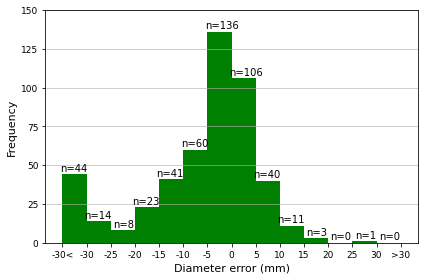

Mean absolute error of diameter (mm): 10.7
Maximum absolute error of diameter (mm): 123.1
Root mean square error of diameter (mm): 18.7

Percentage of errors less than 10 mm (count/total): 70.2\% (342/487)
Percentage of errors less than 20 mm (count/total): 86.2\% (420/487)
Percentage of errors less than 30 mm (count/total): 91.0\% (443/487)
Percentage of errors higher than 30 mm (count/total): 9.0\% (44/487)

ORCNN


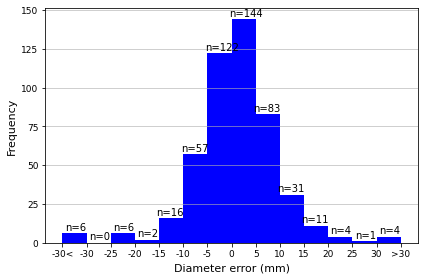

Mean absolute error of diameter (mm): 6.4
Maximum absolute error of diameter (mm): 74.2
Root mean square error of diameter (mm): 9.7

Percentage of errors less than 10 mm (count/total): 83.4\% (406/487)
Percentage of errors less than 20 mm (count/total): 95.7\% (466/487)
Percentage of errors less than 30 mm (count/total): 97.9\% (477/487)
Percentage of errors higher than 30 mm (count/total): 2.1\% (10/487)



In [5]:
# colors = colors[::-1]

csv_name = 'summary_stats_diameter_error.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['sumstats', 'mrcnn', 'orcnn'])
    
writelines = ["Mean absolute error of diameter (mm)", "Maximum absolute error of diameter (mm)", 
              "Root mean square error of diameter (mm)", 
              "Percentage of errors less than 10 mm (count/total)",
              "Percentage of errors less than 20 mm (count/total)",
              "Percentage of errors less than 30 mm (count/total)",
              "Percentage of errors higher than 30 mm (count/total)"]

array = np.empty([len(writelines), 3], dtype="U79")

for r in range(len(writelines)):
    writeline = writelines[r]
    array[r, 0] = writeline

              
for i in range(len(labels)):
    label = labels[i]
    print(label)
    subdir = subdirs[i]
    color = colors[i]
    savename = os.path.join(rootdir, "histogram_" + subdir + ".jpg")
    bins, counts = statistics.histogram_error_fixed_scale(np.asarray(diffs[label]), label, -35, 35, 70, 14, digit_size, font_size, color, savename)

    mae = mean_absolute_error(real_diameters[label], pred_diameters[label])
    mae_string = "{0:.1f}".format(mae)
    max_diff_string = "{0:.1f}".format(max_diff[label])
    
    print(writelines[0] + ": " + mae_string)
    print(writelines[1] + ": " + max_diff_string)
    
    array[0, i+1] = mae_string
    array[1, i+1] = max_diff_string

    
    rmse = mean_squared_error(real_diameters[label], pred_diameters[label], squared=False)
    rmse_string = "{0:.1f}".format(rmse)
    print(writelines[2] + ": " + rmse_string)
    array[2, i+1] = rmse_string
    
    print("")
    
    values = [10, 20, 30]
    for j in range(len(values)):
        value = values[j]
        prec, sum_between, sum_all, value = statistics.counts_between(bins, counts, value)
        sum_string = "{0:.1f}\% ({1:.0f}/{2:.0f})".format(prec, sum_between, sum_all, value)
        print(writelines[j+3] + ": " + sum_string)
        array[j+3, i+1] = sum_string

    prec, sum_larger, sum_all, value = statistics.counts_larger(bins, counts, 30)
    sum_string = "{0:.1f}\% ({1:.0f}/{2:.0f})".format(prec, sum_larger, sum_all, value)
    print(writelines[6] + ": " + sum_string)
    array[6, i+1] = sum_string
    
    print("")


for r in range(len(writelines)):
    writeline = array[r]
    with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow(writeline)

## Plot a combined empirical cumulative distribution function

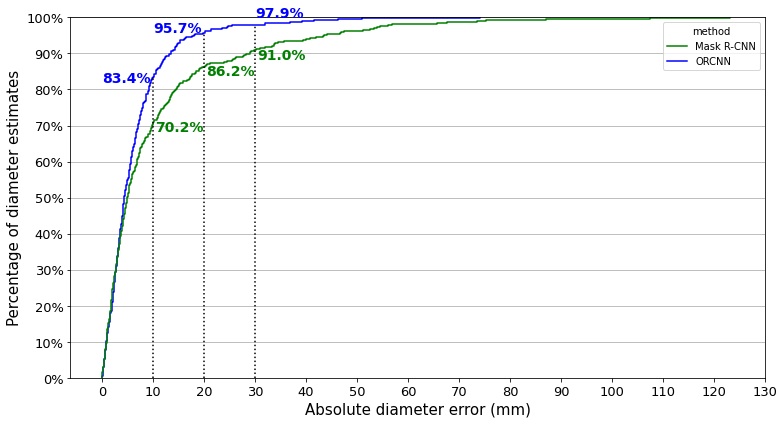

In [6]:
font_size = 15
digit_size = 13
annot_size = 14

f, ax = plt.subplots(figsize=(11, 6))

ax = sns.ecdfplot(data=df, x="abs_diff", hue="method", stat="proportion", palette=palette)

y_ticks_list = []

for j in range(0, 110, 10):
    y_ticks_list.append('{0:d}%'.format(j))

plt.xticks(range(0, 140, 10), fontsize=digit_size)
plt.yticks(np.arange(0, 1.1, 0.1), y_ticks_list, fontsize=digit_size)
plt.xlabel("Absolute diameter error (mm)", fontsize=font_size)
plt.ylabel("Percentage of diameter estimates", fontsize=font_size)
plt.grid(which='major', axis='y', linestyle='-')

plt.axvline(x=10, ymin=0, ymax=0.836, color='k', linestyle='dotted')
plt.axvline(x=20, ymin=0, ymax=0.955, color='k', linestyle='dotted')
plt.axvline(x=30, ymin=0, ymax=0.979, color='k', linestyle='dotted')

# annotate the percentages for Mask R-CNN
plt.annotate('70.2%', (10.5, 0.685), fontsize=annot_size, weight='bold', color='green')
plt.annotate('86.2%', (20.5, 0.84), fontsize=annot_size, weight='bold', color='green')
plt.annotate('91.0%', (30.5, 0.885), fontsize=annot_size, weight='bold', color='green')

# annotate the percentages for ORCNN
plt.annotate('83.4%', (0, 0.82), fontsize=annot_size, weight='bold', color='blue')
plt.annotate('95.7%', (10, 0.96), fontsize=annot_size, weight='bold', color='blue')
plt.annotate('97.9%', (30, 1), fontsize=annot_size, weight='bold', color='blue')

plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'cumulative_count_diameter_error.jpg'))
plt.show()

## Store the unique occlusion rates as 10 bins

In [7]:
unique_ocrs = list(set(df["ocr"]))
unique_ocrs.sort()
ocr_counts = np.zeros(len(unique_ocrs)).astype(np.uint8)

x_ticks_list = []

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]
    ocr_count = int(len(np.where(df["ocr"] == unique_ocr)[0])/2)
    ocr_counts[j] = ocr_count

    x_ticks_list.append('{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr))

## Make a combined line-plot of the amodal IoU as a function of the occlusion rate

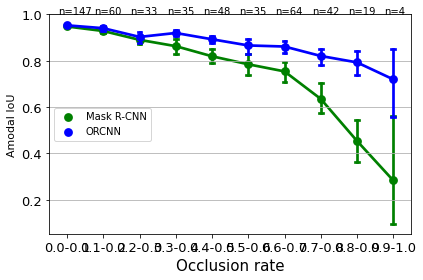

In [8]:
g = sns.pointplot(x="ocr", y="amodal_iou", hue="method", ci=95, palette=palette, data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 1))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(fontsize=digit_size)
plt.ylabel("Amodal IoU", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'amodal_IoU_occlusion_rate.jpg'))
plt.show()

## Make a combined line-plot of the visible IoU as a function of the occlusion rate

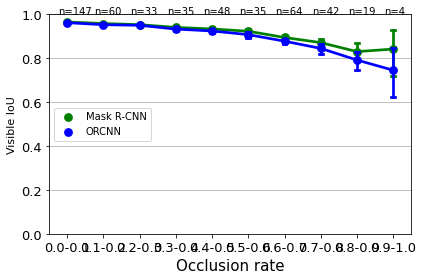

In [9]:
g = sns.pointplot(x="ocr", y="visible_iou", hue="method", ci=95, palette=palette, data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 1))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(np.arange(0, 1.2, 0.2), fontsize=digit_size)
plt.ylabel("Visible IoU", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'visible_IoU_occlusion_rate.jpg'))
plt.show()

## Make a combined line-plot of the diameter error as a function of the occlusion rate

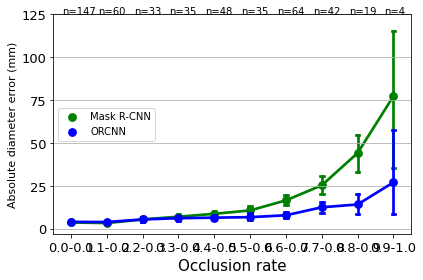

In [10]:
bin_step = 25
max_val = statistics.ceil_to_25(np.max(df["abs_diff"]))

g = sns.pointplot(x="ocr", y="abs_diff", hue="method", ci=95, palette=palette, data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 125))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(range(0, int(max_val) + bin_step, bin_step), fontsize=digit_size)
plt.ylabel("Absolute diameter error (mm)", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'diameter_error_occlusion_rate.jpg'))
plt.show()

## Make a dual y-axis line-plot of the diameter error and the amodal IoU as a function of the occlusion rate

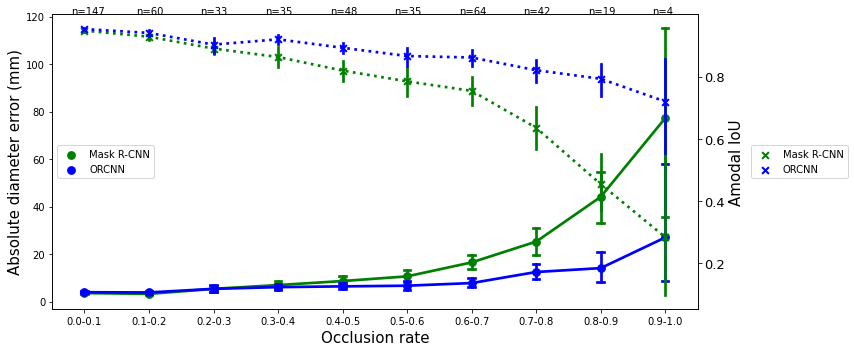

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 5))
g1 = sns.pointplot(x="ocr", y="abs_diff", hue="method", ci=95, palette=palette, data=df, ax=ax1, capsize=.1)
g1.get_legend().remove()
ax1.set_xlabel("Occlusion rate", fontsize=font_size)
ax1.set_ylabel("Absolute diameter error (mm)", fontsize=font_size)
ax1.legend(loc='center left')

ax2 = ax1.twinx()
g2 = sns.pointplot(x="ocr", y="amodal_iou", hue="method", ci=95, palette=palette, data=df, ax=ax2, markers=["x", "x", "x"], linestyles=[":", ":", ":"])
g2.get_legend().remove()
ax2.set_ylabel("Amodal IoU", fontsize=font_size)
ax2.legend(loc='center left', bbox_to_anchor=(1.075, 0.5))

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.2, 1))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.yticks(fontsize=digit_size)

plt.tight_layout()
plt.show()

## Filter the image analysis times on equal numbers of detection for both methods

In [12]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

num_of_det = df.groupby(["name", "method"])["det_num"].apply(list)

ids1 = np.arange(0, len(num_of_det), 2)
ids2 = np.arange(1, len(num_of_det), 2)

det_mrcnn = np.zeros(len(ids1)).astype(np.float32)
det_orcnn = np.zeros(len(ids2)).astype(np.float32)

for i in range(len(num_of_det)):
    if i in ids1:
        idx = int(i/2)
        det_mrcnn[idx] = num_of_det[i][0]
    if i in ids2:
        idx = int((i-1)/2)
        det_orcnn[idx] = num_of_det[i][0]

idxs = list(np.where(det_mrcnn == det_orcnn)[0])

selected_names = df.iloc[idxs]["name"].tolist()
df2 = df.loc[df["name"].isin(selected_names)]

## Boxplot with the inference times for all methods

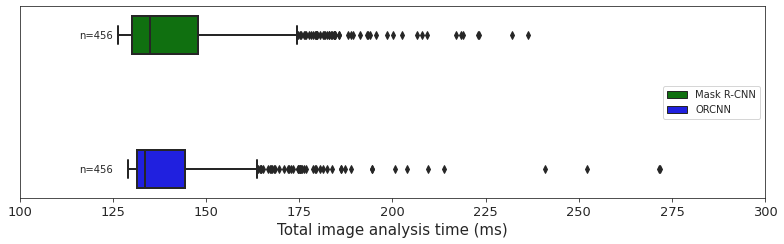

In [13]:
sns.set_style("ticks")
f, ax = plt.subplots(figsize=(11, 3.5))

ax = sns.boxplot(x="time", y="method_id", hue="method", orient="h", palette=palette, linewidth=2, data=df2)
ax.set_ylabel('')
plt.legend(loc='center right')

plt.xlabel('Total image analysis time (ms)', fontsize=font_size)
plt.xticks(np.arange(100, 325, step=25), fontsize=digit_size)

plt.xticks(fontsize=digit_size)
plt.yticks([])

plt.annotate('n={:.0f}'.format(df2.shape[0]/2), (116, -0.17))
plt.annotate('n={:.0f}'.format(df2.shape[0]/2), (116, 1.23))

plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'image_analysis_times.jpg'))
plt.show()

## Wilcoxon Signed-Rank Test of the image analysis time

In [14]:
time_list = ["time_cnn", "time_cf", "time_hf", "time_pm", "time"]
time_labels = ["CNN segmentation", "Circle-fit", "Histogram filtering", "Pixel-to-mm calculation", "Total time"]
alpha = 0.05
print("{:<25} {:<51} {:<25}".format('', 'AVG (STD) of Image Analysis Time (ms)', 'P-value Wilcoxon'))
print("{:<25} {:<25} {:<25} {:<25}".format('Time component', 'MP', 'OP', 'MP-OP'))

csv_name = 'analysis_times.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['component', 'mrcnn', 'orcnn', 'p'])

for i in range(len(time_list)):
    time_component = time_list[i]
    time_label = time_labels[i]
    times = df2.groupby(["name", "method"])[time_component].apply(list)
    times_mp = np.zeros(int(len(times)/2)).astype(np.float32)
    times_op = np.zeros(int(len(times)/2)).astype(np.float32)

    for i in range(len(times)):
        if (i % 2) == 0:
            idx = int(i/2)
            times_mp[idx] = times[i][0]
        else:
            idx = int((i-1)/2)
            times_op[idx] = times[i][0]


    stat, p_mp_op = wilcoxon(times_mp, times_op)

    if p_mp_op > 0.05:
        sign = "ns"
    elif 0.01 < p_mp_op <= 0.05:
        sign = "*"
    elif 0.001 < p_mp_op <= 0.01:
        sign = "**"
    elif 0.0001 < p_mp_op <= 0.001:
        sign = "***"
    elif p_mp_op <= 0.0001:
        sign = "****"

    avgstd_mp = '{0:.1f} ({1:.1f})'.format(np.average(times_mp), np.std(times_mp))
    avgstd_op = '{0:.1f} ({1:.1f})'.format(np.average(times_op), np.std(times_op))
    p_mp_op = '{0:.2f} ({1})'.format(p_mp_op, sign)

    print("{:<25} {:<25} {:<25} {:<25}".format(time_label, avgstd_mp, avgstd_op, p_mp_op))
    
    with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        csvwriter.writerow([time_label, avgstd_mp, avgstd_op, p_mp_op])

print("")
print("Explanation:")
print("MP-OP : rank comparison between Mask R-CNN & Post-processing and ORCNN & Post-processing")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                          AVG (STD) of Image Analysis Time (ms)               P-value Wilcoxon         
Time component            MP                        OP                        MP-OP                    
CNN segmentation          124.8 (4.0)               126.3 (2.0)               0.00 (****)              
Circle-fit                11.7 (14.8)               8.0 (13.4)                0.00 (****)              
Histogram filtering       4.3 (1.8)                 4.3 (1.8)                 0.02 (*)                 
Pixel-to-mm calculation   2.8 (4.4)                 3.4 (5.3)                 0.00 (****)              
Total time                143.6 (20.6)              142.0 (18.7)              0.27 (ns)                

Explanation:
MP-OP : rank comparison between Mask R-CNN & Post-processing and ORCNN & Post-processing

The P-values lower than 0.05 indicate that the tested distributions are significantly different


## Wilcoxon Signed-Rank Test of visible IoU for each occlusion rate

In [15]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
csv_name = 'wilcoxon_visible_IoU.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['ocr', 'mrcnn', 'orcnn', 'p'])

iou = df.groupby(["name", "ocr", "method"])["visible_iou"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(iou), 2)
ids2 = np.arange(1, len(iou), 2)

iou_mp = np.zeros(len(ids1)).astype(np.float32)
iou_op = np.zeros(len(ids2)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(iou)):
    if i in ids1:
        idx = int(i/2)
        iou_mp[idx] = iou[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/2)
        iou_op[idx] = iou[i][0]
        
alpha = 0.05
print("{:<25} {:<51} {:<25}".format('', 'AVG (STD) of Visible Intersection over Union', 'P-value Wilcoxon'))
print("{:<25} {:<25} {:<25} {:<25}".format('Occlusion rate', 'MP', 'OP', 'MP-OP'))

for j in range(len(unique_ocrs)+1):
    
    if j != len(unique_ocrs):
        unique_ocr = unique_ocrs[j]    
        idxs = np.where(ocrs == unique_ocr)[0]

        m_p = []
        o_p = []

        for k in range(len(idxs)):
            idx = idxs[k]
            m_p.append(iou_mp[idx])
            o_p.append(iou_op[idx])

        stat, p_mp_op = wilcoxon(m_p, o_p)

        if p_mp_op > 0.05:
            sign = "ns"
        elif 0.01 < p_mp_op <= 0.05:
            sign = "*"
        elif 0.001 < p_mp_op <= 0.01:
            sign = "**"
        elif 0.0001 < p_mp_op <= 0.001:
            sign = "***"
        elif p_mp_op <= 0.0001:
            sign = "****"

        ocr_string = '{0:.1f}-{1:.1f} (n={2:d})'.format(unique_ocr-0.1, unique_ocr, len(idxs))
        avgstd_mp = '{0:.2f} ({1:.2f})'.format(np.average(m_p), np.std(m_p))
        avgstd_op = '{0:.2f} ({1:.2f})'.format(np.average(o_p), np.std(o_p))

        if j != (len(unique_ocrs)-1):
            p_mp_op = '{0:.2f} ({1})'.format(p_mp_op, sign)
        else:
            p_mp_op = '-'

        print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))

        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, avgstd_mp, avgstd_op, p_mp_op])
        
    else:
        stat, p_mp_op = wilcoxon(iou_mp, iou_op)

        if p_mp_op > 0.05:
            sign = "ns"
        elif 0.01 < p_mp_op <= 0.05:
            sign = "*"
        elif 0.001 < p_mp_op <= 0.01:
            sign = "**"
        elif 0.0001 < p_mp_op <= 0.001:
            sign = "***"
        elif p_mp_op <= 0.0001:
            sign = "****"

        ocr_string = 'All (n={0:d})'.format(len(iou_mp))
        avgstd_mp = '{0:.2f} ({1:.2f})'.format(np.average(iou_mp), np.std(iou_mp))
        avgstd_op = '{0:.2f} ({1:.2f})'.format(np.average(iou_op), np.std(iou_op))
        p_mp_op = '{0:.2f} ({1})'.format(p_mp_op, sign)
        
        print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))
        
        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, avgstd_mp, avgstd_op, p_mp_op])

    
print("")
print("Explanation:")
print("MP : Mask R-CNN & Post-processing")
print("OP : ORCNN & Post-processing")
print("")
print("MP-OP : rank comparison between Mask R-CNN & Post-processing and ORCNN & Post-processing")
print("")
print("- : sample size too small for normal approximation")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                          AVG (STD) of Visible Intersection over Union        P-value Wilcoxon         
Occlusion rate            MP                        OP                        MP-OP                    
0.0-0.1 (n=147)           0.97 (0.01)               0.96 (0.01)               0.00 (****)              
0.1-0.2 (n=60)            0.96 (0.01)               0.95 (0.01)               0.00 (****)              
0.2-0.3 (n=33)            0.95 (0.01)               0.95 (0.01)               0.08 (ns)                
0.3-0.4 (n=35)            0.94 (0.02)               0.93 (0.02)               0.00 (****)              
0.4-0.5 (n=48)            0.93 (0.03)               0.92 (0.03)               0.00 (****)              
0.5-0.6 (n=35)            0.92 (0.03)               0.91 (0.04)               0.00 (****)              
0.6-0.7 (n=64)            0.89 (0.05)               0.88 (0.05)               0.00 (****)              
0.7-0.8 (n=42)            0.87 (0.06)               0.85 (0.07) 

## Wilcoxon Signed-Rank Test of amodal IoU for each occlusion rate

In [16]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
csv_name = 'wilcoxon_amodal_IoU.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['ocr', 'mrcnn', 'orcnn', 'p'])

iou = df.groupby(["name", "ocr", "method"])["amodal_iou"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(iou), 2)
ids2 = np.arange(1, len(iou), 2)

iou_mp = np.zeros(len(ids1)).astype(np.float32)
iou_op = np.zeros(len(ids2)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(iou)):
    if i in ids1:
        idx = int(i/2)
        iou_mp[idx] = iou[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/2)
        iou_op[idx] = iou[i][0]
        
alpha = 0.05
print("{:<25} {:<51} {:<25}".format('', 'AVG (STD) of Amodal Intersection over Union', 'P-value Wilcoxon'))
print("{:<25} {:<25} {:<25} {:<25}".format('Occlusion rate', 'MP', 'OP', 'MP-OP'))

for j in range(len(unique_ocrs)+1):
    
    if j != len(unique_ocrs):
        unique_ocr = unique_ocrs[j]    
        idxs = np.where(ocrs == unique_ocr)[0]

        m_p = []
        o_p = []

        for k in range(len(idxs)):
            idx = idxs[k]
            m_p.append(iou_mp[idx])
            o_p.append(iou_op[idx])

        stat, p_mp_op = wilcoxon(m_p, o_p)

        if p_mp_op > 0.05:
            sign = "ns"
        elif 0.01 < p_mp_op <= 0.05:
            sign = "*"
        elif 0.001 < p_mp_op <= 0.01:
            sign = "**"
        elif 0.0001 < p_mp_op <= 0.001:
            sign = "***"
        elif p_mp_op <= 0.0001:
            sign = "****"

        ocr_string = '{0:.1f}-{1:.1f} (n={2:d})'.format(unique_ocr-0.1, unique_ocr, len(idxs))
        avgstd_mp = '{0:.2f} ({1:.2f})'.format(np.average(m_p), np.std(m_p))
        avgstd_op = '{0:.2f} ({1:.2f})'.format(np.average(o_p), np.std(o_p))

        if j != (len(unique_ocrs)-1):
            p_mp_op = '{0:.2f} ({1})'.format(p_mp_op, sign)
        else:
            p_mp_op = '-'

        print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))

        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, avgstd_mp, avgstd_op, p_mp_op])
    else:
        stat, p_mp_op = wilcoxon(iou_mp, iou_op)

        if p_mp_op > 0.05:
            sign = "ns"
        elif 0.01 < p_mp_op <= 0.05:
            sign = "*"
        elif 0.001 < p_mp_op <= 0.01:
            sign = "**"
        elif 0.0001 < p_mp_op <= 0.001:
            sign = "***"
        elif p_mp_op <= 0.0001:
            sign = "****"

        ocr_string = 'All (n={0:d})'.format(len(iou_mp))
        avgstd_mp = '{0:.2f} ({1:.2f})'.format(np.average(iou_mp), np.std(iou_mp))
        avgstd_op = '{0:.2f} ({1:.2f})'.format(np.average(iou_op), np.std(iou_op))
        p_mp_op = '{0:.2f} ({1})'.format(p_mp_op, sign)
        
        print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))
        
        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, avgstd_mp, avgstd_op, p_mp_op])
    
print("")
print("Explanation:")
print("MP : Mask R-CNN & Post-processing")
print("OP : ORCNN & Post-processing")
print("")
print("MP-OP : rank comparison between Mask R-CNN & Post-processing and ORCNN & Post-processing")
print("")
print("- : sample size too small for normal approximation")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                          AVG (STD) of Amodal Intersection over Union         P-value Wilcoxon         
Occlusion rate            MP                        OP                        MP-OP                    
0.0-0.1 (n=147)           0.95 (0.03)               0.95 (0.03)               0.00 (**)                
0.1-0.2 (n=60)            0.93 (0.04)               0.94 (0.04)               0.00 (***)               
0.2-0.3 (n=33)            0.89 (0.06)               0.90 (0.07)               0.17 (ns)                
0.3-0.4 (n=35)            0.86 (0.09)               0.92 (0.04)               0.00 (**)                
0.4-0.5 (n=48)            0.82 (0.11)               0.89 (0.06)               0.00 (****)              
0.5-0.6 (n=35)            0.78 (0.13)               0.87 (0.09)               0.00 (**)                
0.6-0.7 (n=64)            0.75 (0.18)               0.86 (0.11)               0.00 (****)              
0.7-0.8 (n=42)            0.64 (0.22)               0.82 (0.12) 

## Wilcoxon Signed-Rank Test of diameter error for each occlusion rate

In [17]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
csv_name = 'wilcoxon_diameter_error.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['ocr', 'mrcnn', 'orcnn', 'p'])
    
abs_diff = df.groupby(["name", "ocr", "method"])["abs_diff"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(abs_diff), 2)
ids2 = np.arange(1, len(abs_diff), 2)

abs_diff_mp = np.zeros(len(ids1)).astype(np.float32)
abs_diff_op = np.zeros(len(ids2)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(abs_diff)):
    if i in ids1:
        idx = int(i/2)
        abs_diff_mp[idx] = abs_diff[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/2)
        abs_diff_op[idx] = abs_diff[i][0]
        
alpha = 0.05
print("{:<25} {:<51} {:<25}".format('', 'AVG (STD) of absolute diameter error (mm)', 'P-value Wilcoxon'))
print("{:<25} {:<25} {:<25} {:<25}".format('Occlusion rate', 'MP', 'OP', 'MP-OP'))

for j in range(len(unique_ocrs)+1):
    
    if j != len(unique_ocrs):
        unique_ocr = unique_ocrs[j]    
        idxs = np.where(ocrs == unique_ocr)[0]

        m_p = []
        o_p = []

        for k in range(len(idxs)):
            idx = idxs[k]
            m_p.append(abs_diff_mp[idx])
            o_p.append(abs_diff_op[idx])

        stat, p_mp_op = wilcoxon(m_p, o_p)

        if p_mp_op > 0.05:
            sign = "ns"
        elif 0.01 < p_mp_op <= 0.05:
            sign = "*"
        elif 0.001 < p_mp_op <= 0.01:
            sign = "**"
        elif 0.0001 < p_mp_op <= 0.001:
            sign = "***"
        elif p_mp_op <= 0.0001:
            sign = "****"

        ocr_string = '{0:.1f}-{1:.1f} (n={2:d})'.format(unique_ocr-0.1, unique_ocr, len(idxs))
        avgstd_mp = '{0:.1f} ({1:.1f})'.format(np.average(m_p), np.std(m_p))
        avgstd_op = '{0:.1f} ({1:.1f})'.format(np.average(o_p), np.std(o_p))

        if j != (len(unique_ocrs)-1):
            p_mp_op = '{0:.2f} ({1})'.format(p_mp_op, sign)
        else:
            p_mp_op = '-'

        print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))

        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, avgstd_mp, avgstd_op, p_mp_op])
            
    else:
        stat, p_mp_op = wilcoxon(abs_diff_mp, abs_diff_op)

        if p_mp_op > 0.05:
            sign = "ns"
        elif 0.01 < p_mp_op <= 0.05:
            sign = "*"
        elif 0.001 < p_mp_op <= 0.01:
            sign = "**"
        elif 0.0001 < p_mp_op <= 0.001:
            sign = "***"
        elif p_mp_op <= 0.0001:
            sign = "****"

        ocr_string = 'All (n={0:d})'.format(len(abs_diff_mp))
        avgstd_mp = '{0:.1f} ({1:.1f})'.format(np.average(abs_diff_mp), np.std(abs_diff_mp))
        avgstd_op = '{0:.1f} ({1:.1f})'.format(np.average(abs_diff_op), np.std(abs_diff_op))
        p_mp_op = '{0:.2f} ({1})'.format(p_mp_op, sign)
        
        print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))
        
        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, avgstd_mp, avgstd_op, p_mp_op])
    
print("")
print("Explanation:")
print("MP : Mask R-CNN & Post-processing")
print("OP : ORCNN & Post-processing")
print("")
print("MP-OP : rank comparison between Mask R-CNN & Post-processing and ORCNN & Post-processing")
print("")
print("- : sample size too small for normal approximation")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                          AVG (STD) of absolute diameter error (mm)           P-value Wilcoxon         
Occlusion rate            MP                        OP                        MP-OP                    
0.0-0.1 (n=147)           3.6 (3.1)                 3.9 (2.9)                 0.11 (ns)                
0.1-0.2 (n=60)            3.2 (2.5)                 3.8 (2.4)                 0.05 (ns)                
0.2-0.3 (n=33)            5.4 (4.1)                 5.4 (4.0)                 0.63 (ns)                
0.3-0.4 (n=35)            7.0 (4.8)                 6.1 (4.5)                 0.39 (ns)                
0.4-0.5 (n=48)            8.6 (7.0)                 6.4 (4.8)                 0.09 (ns)                
0.5-0.6 (n=35)            10.6 (7.8)                6.7 (6.0)                 0.01 (*)                 
0.6-0.7 (n=64)            16.5 (13.6)               7.8 (7.8)                 0.00 (****)              
0.7-0.8 (n=42)            25.3 (18.4)               12.5 (10.2) 

## RMSE of the diameter for each occlusion rate

In [18]:
csv_name = 'rmse.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['ocr', 'mrcnn', 'orcnn'])
    
pred_diameters_all = df.groupby(["method"])["pred_d"].apply(list)
real_diameters_all = df.groupby(["method"])["real_d"].apply(list)

pred_diameters = df.groupby(["name", "ocr", "method"])["pred_d"].apply(list)
real_diameters = df.groupby(["name", "ocr", "method"])["real_d"].apply(list)

ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(abs_diff), 2)
ids2 = np.arange(1, len(abs_diff), 2)

pred_diameters_mrcnn = np.zeros(len(ids1)).astype(np.float32)
real_sizes = np.zeros(len(ids1)).astype(np.float32)

pred_diameters_orcnn = np.zeros(len(ids2)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(pred_diameters)):
    if i in ids1:
        idx = int(i/2)
        pred_diameters_mrcnn[idx] = pred_diameters[i][0]
        real_sizes[idx] = real_diameters[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/2)
        pred_diameters_orcnn[idx] = pred_diameters[i][0]
        

print("{:<25} {:<51}".format('', 'RMSE of the diameter (mm)'))
print("{:<25} {:<25} {:<25}".format('Occlusion rate', 'MP', 'OP'))

for j in range(len(unique_ocrs)+1):
    
    if j != len(unique_ocrs):
        unique_ocr = unique_ocrs[j]    
        idxs = np.where(ocrs == unique_ocr)[0]

        pred_mrcnn = []
        pred_orcnn = []
        real_size = []

        for k in range(len(idxs)):
            idx = idxs[k]
            pred_mrcnn.append(pred_diameters_mrcnn[idx])
            pred_orcnn.append(pred_diameters_orcnn[idx])
            real_size.append(real_sizes[idx])


        rmse_mrcnn = mean_squared_error(real_size, pred_mrcnn, squared=False)
        rmse_orcnn = mean_squared_error(real_size, pred_orcnn, squared=False)

        rmse_mrcnn_string = "{0:.1f}".format(rmse_mrcnn)
        rmse_orcnn_string = "{0:.1f}".format(rmse_orcnn)
        ocr_string = '{0:.1f}-{1:.1f} (n={2:d})'.format(unique_ocr-0.1, unique_ocr, len(idxs))

        print("{:<25} {:<25} {:<25}".format(ocr_string, rmse_mrcnn_string, rmse_orcnn_string))

        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, rmse_mrcnn_string, rmse_orcnn_string])
    else:
        rmse_m_all = mean_squared_error(real_diameters_all["Mask R-CNN"], pred_diameters_all["Mask R-CNN"], squared=False)
        rmse_o_all = mean_squared_error(real_diameters_all["ORCNN"], pred_diameters_all["ORCNN"], squared=False)
        
        ocr_string = 'All (n={0:d})'.format(len(real_diameters_all["Mask R-CNN"]))
        rmse_mrcnn_string = "{0:.1f}".format(rmse_m_all)
        rmse_orcnn_string = "{0:.1f}".format(rmse_o_all)
        
        print("{:<25} {:<25} {:<25}".format(ocr_string, rmse_mrcnn_string, rmse_orcnn_string))
        
        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, rmse_mrcnn_string, rmse_orcnn_string])

                          RMSE of the diameter (mm)                          
Occlusion rate            MP                        OP                       
0.0-0.1 (n=147)           4.7                       4.9                      
0.1-0.2 (n=60)            4.1                       4.5                      
0.2-0.3 (n=33)            6.8                       6.7                      
0.3-0.4 (n=35)            8.4                       7.5                      
0.4-0.5 (n=48)            11.1                      8.0                      
0.5-0.6 (n=35)            13.2                      9.0                      
0.6-0.7 (n=64)            21.4                      11.1                     
0.7-0.8 (n=42)            31.2                      16.1                     
0.8-0.9 (n=19)            50.2                      19.7                     
0.9-1.0 (n=4)             88.5                      38.5                     
All (n=487)               18.7                      9.7         

## Median absolute error of the diameter for each occlusion rate

In [19]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
csv_name = 'median_diameter_error.csv'
with open(os.path.join(rootdir, csv_name), 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(['ocr', 'mrcnn', 'orcnn'])
    
diff = df.groupby(["name", "ocr", "method"])["diff"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(diff), 2)
ids2 = np.arange(1, len(diff), 2)

diff_mp = np.zeros(len(ids1)).astype(np.float32)
diff_op = np.zeros(len(ids2)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(diff)):
    if i in ids1:
        idx = int(i/2)
        diff_mp[idx] = diff[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/2)
        diff_op[idx] = diff[i][0]
        
alpha = 0.05
print("{:<25} {:<51}".format('', 'Median diameter error (mm) and median absolute diameter error (mm)'))
print("{:<25} {:<25} {:<25}".format('Occlusion rate', 'MP', 'OP'))

for j in range(len(unique_ocrs)+1):
    if j != len(unique_ocrs):
        unique_ocr = unique_ocrs[j]    
        idxs = np.where(ocrs == unique_ocr)[0]

        m_p = []
        o_p = []

        for k in range(len(idxs)):
            idx = idxs[k]
            m_p.append(diff_mp[idx])
            o_p.append(diff_op[idx])
            
        median_mrcnn = np.median(m_p)
        median_orcnn = np.median(o_p)
        median_abs_mrcnn = median_abs_deviation(m_p)
        median_abs_orcnn = median_abs_deviation(o_p)

        median_abs_mrcnn_string = "{0:.1f} ({1:.1f})".format(median_mrcnn, median_abs_mrcnn)
        median_abs_orcnn_string = "{0:.1f} ({1:.1f})".format(median_orcnn, median_abs_orcnn)
        ocr_string = '{0:.1f}-{1:.1f} (n={2:d})'.format(unique_ocr-0.1, unique_ocr, len(idxs))

        print("{:<25} {:<25} {:<25}".format(ocr_string, median_abs_mrcnn_string, median_abs_orcnn_string))

        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, median_abs_mrcnn_string, median_abs_orcnn_string])
    else:
        median_mrcnn = np.median(diff_mp)
        median_orcnn = np.median(diff_op)
        median_abs_mrcnn = median_abs_deviation(diff_mp)
        median_abs_orcnn = median_abs_deviation(diff_op)
        
        ocr_string = 'All (n={0:d})'.format(len(diff_mp))
        median_abs_mrcnn_string = "{0:.1f} ({1:.1f})".format(median_mrcnn, median_abs_mrcnn)
        median_abs_orcnn_string = "{0:.1f} ({1:.1f})".format(median_orcnn, median_abs_orcnn)
        
        print("{:<25} {:<25} {:<25}".format(ocr_string, median_abs_mrcnn_string, median_abs_orcnn_string))
        
        with open(os.path.join(rootdir, csv_name), 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csvwriter.writerow([ocr_string, median_abs_mrcnn_string, median_abs_orcnn_string])

                          Median diameter error (mm) and median absolute diameter error (mm)
Occlusion rate            MP                        OP                       
0.0-0.1 (n=147)           1.9 (4.3)                 1.4 (4.9)                
0.1-0.2 (n=60)            -1.5 (3.6)                -1.5 (3.6)               
0.2-0.3 (n=33)            -2.4 (6.2)                1.6 (5.6)                
0.3-0.4 (n=35)            -4.0 (8.9)                2.5 (8.0)                
0.4-0.5 (n=48)            -6.4 (6.9)                3.5 (5.8)                
0.5-0.6 (n=35)            -10.9 (10.5)              -0.5 (7.3)               
0.6-0.7 (n=64)            -11.1 (9.6)               0.6 (7.3)                
0.7-0.8 (n=42)            -25.9 (24.6)              2.2 (14.8)               
0.8-0.9 (n=19)            -44.2 (31.9)              -7.1 (12.5)              
0.9-1.0 (n=4)             -87.3 (41.5)              -12.8 (6.3)              
All (n=487)               -2.4 (7.9)             

## Correlation coefficient between amodal IoU and sizing error

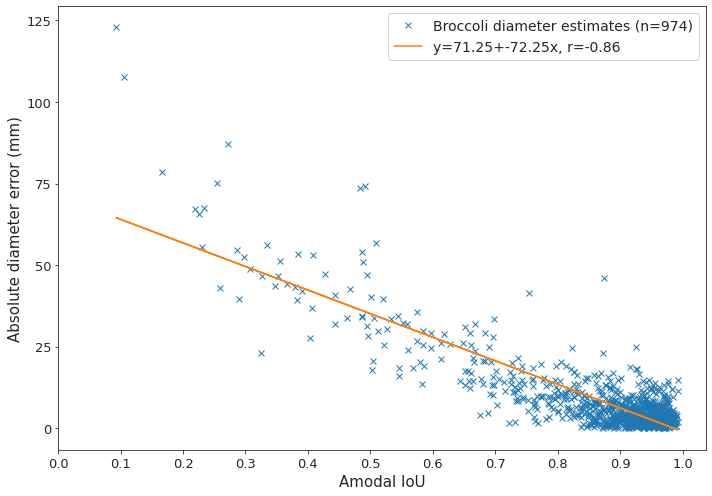

In [20]:
## thanks to: https://realpython.com/numpy-scipy-pandas-correlation-python/
slope, intercept, r, p, stderr = linregress(df["amodal_iou"], df["abs_diff"])
line = f'y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(df["amodal_iou"], df["abs_diff"], linewidth=0, marker='x', label='Broccoli diameter estimates (n={})'.format(len(df["abs_diff"])))
ax.plot(df["amodal_iou"], intercept + slope * df["amodal_iou"], label=line)
ax.set_ylabel('Absolute diameter error (mm)', fontsize=font_size)
ax.set_xlabel('Amodal IoU', fontsize=font_size)
plt.xticks(np.arange(0.0, 1.1, step=0.1), fontsize=digit_size)
plt.yticks(np.arange(0, 150, step=25), fontsize=digit_size)
plt.legend(loc='upper right', fontsize=annot_size)
plt.tight_layout()
plt.savefig(os.path.join(rootdir, 'correlation_coefficient.jpg'))
plt.show()